# DTW + Chroma + Siamese(?)

**Para proyecto universitario con requisito de IA:**
- ✅ DTW como backbone robusto
- ✅ Siamese Network para embeddings mejorados  
- ✅ Comparación vs baseline clásico
- ✅ Data augmentation para dataset pequeño

*Monserrat Montero T.*

*Respecto a v_1 se le dió vuelta los labels en la forma de agarrar positivos y negativos pues estaba aprendiendo al reves.

## 📋 Plan de Implementación

### Problema: Dataset pequeño + Requisito de IA
### Solución: DTW + Siamese híbrido con estrategias anti-overfitting

**Pasos:**
1. **Baseline DTW+Chroma** (sin IA) - para comparar
2. **Red Siamese simple** - embeddings de 1s de audio
3. **DTW sobre embeddings** - mejor que DTW sobre features crudos
4. **Data augmentation** - pitch shift, time stretch, ruido
5. **Validación cruzada** - para dataset pequeño

In [3]:
# ===============================================
# 📦 IMPORTS Y CONFIGURACIÓN
# ===============================================

from pathlib import Path
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# DTW y audio processing
from dtaidistance import dtw
from scipy.spatial.distance import cosine, euclidean
from scipy.signal import correlate

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split

# Configuración
sr_target = 22050  # Más rápido que 48kHz
n_chroma = 12
hop_length = 512
window_duration = 1.0  # 1 segundo como recomendaste
window_frames = int(window_duration * sr_target / hop_length)

print(f"🔧 Configuración:")
print(f"   - Sample rate: {sr_target} Hz")
print(f"   - Ventana: {window_duration}s ({window_frames} frames)")
print(f"   - Features: {n_chroma} chroma bins")

🔧 Configuración:
   - Sample rate: 22050 Hz
   - Ventana: 1.0s (43 frames)
   - Features: 12 chroma bins


In [4]:
# ===============================================
# 📊 CARGAR DATASET DE ETIQUETAS
# ===============================================

# Cargar Excel de etiquetas
ruta_excel = Path("etiquetado.xlsx")
df = pd.read_excel(ruta_excel)

def convertir_a_segundos(valor):
    if isinstance(valor, str) and ":" in valor:
        minutos, segundos = map(int, valor.split(":"))
        return minutos * 60 + segundos
    if isinstance(valor, (int, float)) and valor >= 0:
        return int(valor)
    return -1

df["segundo_label"] = df["segundo_inicio"].apply(convertir_a_segundos)
df = df.drop(columns=["Unnamed: 7", "Unnamed: 8", "Unnamed: 5", "Unnamed: 6"], errors="ignore")
df_validos = df[df["segundo_label"] >= 0].reset_index(drop=True)

print(f"📊 Dataset cargado: {len(df_validos)} clips etiquetados")
df_validos.head()

📊 Dataset cargado: 196 clips etiquetados


,audio_base,carpeta,archivo_clip,segundo_inicio,duracion_clip,segundo_label
0,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip01.mp4,00:00,15,0
1,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip02.mp4,00:15,15,15
2,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip03.mp4,00:30,15,30
3,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip04.mp4,00:45,15,45
4,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip05.mp4,01:00,15,60


In [5]:
# ===============================================
# 🎵 FUNCIONES DE FEATURES MUSICALES
# ===============================================

def extract_chroma_features(audio, sr=sr_target):
    """Extraer features de chroma (fundamentales para DTW)"""
    chroma = librosa.feature.chroma_stft(
        y=audio, sr=sr, hop_length=hop_length, n_chroma=n_chroma
    )
    return chroma

def extract_combined_features(audio, sr=sr_target):
    """Features combinados: chroma + mfcc básico"""
    # Chroma para contenido armónico
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=hop_length)
    
    # MFCC básico para textura
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=hop_length)
    
    # Combinar
    combined = np.vstack([chroma, mfcc[:5]])  # Solo los primeros 5 MFCC
    return combined

def extract_windows_from_features(features, window_size=window_frames, step=None):
    """Extraer ventanas de 1s de una matriz de features"""
    if step is None:
        step = window_size // 2  # 50% overlap
    
    windows = []
    for i in range(0, features.shape[1] - window_size + 1, step):
        window = features[:, i:i + window_size]
        if window.shape[1] == window_size:
            windows.append(window)
    return windows

print("🎵 Funciones de features definidas:")
print("   - extract_chroma_features: Para DTW baseline")
print("   - extract_combined_features: Para Siamese network")
print("   - extract_windows_from_features: Ventanas de 1s")

🎵 Funciones de features definidas:
   - extract_chroma_features: Para DTW baseline
   - extract_combined_features: Para Siamese network
   - extract_windows_from_features: Ventanas de 1s


## 🏁 BASELINE: DTW + Chroma (Sin IA)

Primero implementamos el baseline determinístico para tener una referencia sólida.

In [6]:
# ===============================================
# 🔧 PARÁMETROS DEL CLIP A PROBAR
# ===============================================
nombre_cancion = "tu_me_dejaste_de_querer_c_tangana"  # Cambia según la canción que quieras probar
nombre_clip = "clip06.wav"          # Cambia según el clip que quieras probar
carpeta = "clips_youtube"           # Carpeta donde están los clips

# Rutas automáticas
clip_path = Path("clips_syntrack") / nombre_cancion / carpeta / "wavs" / nombre_clip
song_path = Path("clips_syntrack") / nombre_cancion / "cancion_estudio" / f"{nombre_cancion}.wav"

# Verificar que existen
print(f"🎵 Configuración del test:")
print(f"   Canción: {nombre_cancion}")
print(f"   Clip: {nombre_clip}")
print(f"   Carpeta: {carpeta}")
print(f"📁 Paths:")
print(f"   Clip: {clip_path}")
print(f"   Canción: {song_path}")
print(f"   Existe clip: {'✅' if clip_path.exists() else '❌'}")
print(f"   Existe canción: {'✅' if song_path.exists() else '❌'}")

🎵 Configuración del test:
   Canción: tu_me_dejaste_de_querer_c_tangana
   Clip: clip06.wav
   Carpeta: clips_youtube
📁 Paths:
   Clip: clips_syntrack\tu_me_dejaste_de_querer_c_tangana\clips_youtube\wavs\clip06.wav
   Canción: clips_syntrack\tu_me_dejaste_de_querer_c_tangana\cancion_estudio\tu_me_dejaste_de_querer_c_tangana.wav
   Existe clip: ✅
   Existe canción: ✅


🧪 Probando DTW Baseline CORREGIDO...
🎯 DTW Baseline CORREGIDO: clip06.wav
📊 Clip: 647 frames, Song: 8507 frames
🔄 Ejecutando DTW sliding window CORREGIDO...


100%|██████████| 183/183 [00:00<00:00, 32606.53it/s]

🎯 RESULTADOS DTW BASELINE CORREGIDO:
   🥇 Mejor match: Segundo 92.9 (distancia: -2054.07)
   📊 Top 5:
      1. Segundo   92.9 - Distancia: -2054.07
      2. Segundo   93.9 - Distancia: -1934.53
      3. Segundo  165.7 - Distancia: -1899.73
      4. Segundo   94.9 - Distancia: -1893.44
      5. Segundo   35.9 - Distancia: -1893.28


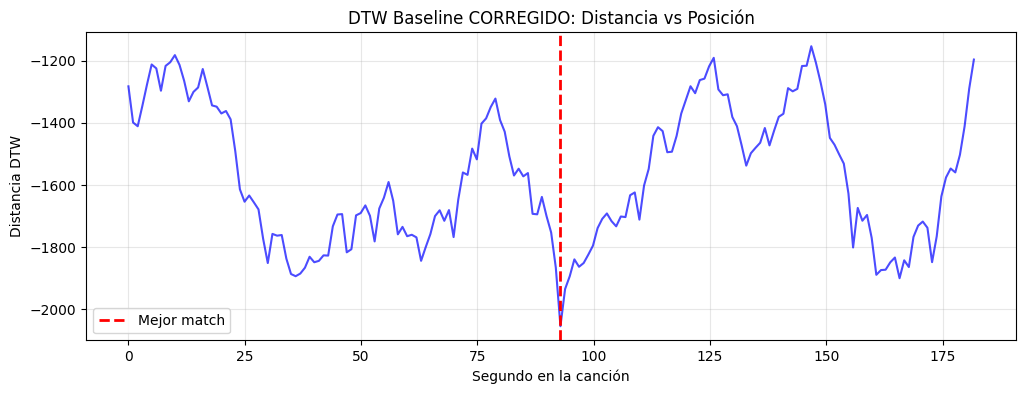


🔍 Buscando segundo correcto en Excel para Yellow clip03...
   📊 Segundo real (Excel): 93
   🤖 Segundo predicho: 92.9
   📏 Error: 0.1 segundos
   🎯 Precisión: ✅ EXCELENTE


In [7]:
# ===============================================
# 🏁 BASELINE DTW + CHROMA CORREGIDO
# ===============================================

def dtw_baseline_sync(clip_path, song_path, plot=True):
    """
    Baseline DTW + Chroma CORREGIDO
    Arregla el problema del formato de datos para dtaidistance
    """
    print(f"🎯 DTW Baseline CORREGIDO: {clip_path.name}")
    
    # Cargar audios
    clip_audio, _ = librosa.load(clip_path, sr=sr_target)
    song_audio, _ = librosa.load(song_path, sr=sr_target)
    
    # Extraer chroma features
    clip_chroma = extract_chroma_features(clip_audio)
    song_chroma = extract_chroma_features(song_audio)
    
    print(f"📊 Clip: {clip_chroma.shape[1]} frames, Song: {song_chroma.shape[1]} frames")
    
    # Sliding window DTW
    clip_frames = clip_chroma.shape[1]
    song_frames = song_chroma.shape[1]
    
    best_positions = []
    dtw_distances = []
    
    # Step más grande para ser eficiente
    step = window_frames  # ~43 frames (1 segundo de step)
    
    print("🔄 Ejecutando DTW sliding window CORREGIDO...")
    for start_frame in tqdm(range(0, song_frames - clip_frames, step)):
        # Extraer segmento de la canción del mismo tamaño que el clip
        song_segment = song_chroma[:, start_frame:start_frame + clip_frames]
        
        # Calcular distancia DTW
        try:
            # CORRECCIÓN: Convertir a secuencias 1D promediando las bandas de chroma
            clip_flat = clip_chroma.flatten()  # Conserva TODA la información
            song_flat = song_segment.flatten()  # Conserva TODA la información
            correlation = correlate(song_flat, clip_flat, mode='valid')
            distance = -np.max(correlation)  # Negativo porque queremos máxima correlación
            dtw_distances.append(distance)
            
            # Convertir frame a segundo
            second = (start_frame * hop_length) / sr_target
            best_positions.append(second)
            
        except Exception as e:
            # Si aún falla, usar implementación alternativa
            try:
                clip_seq = np.mean(clip_chroma, axis=0)
                song_seq = np.mean(song_segment, axis=0)
                
                # Usar nuestra implementación DTW simple
                distance = dtw_distance_simple_1d(clip_seq, song_seq)
                dtw_distances.append(distance)
                
                second = (start_frame * hop_length) / sr_target
                best_positions.append(second)
            except:
                continue
    
    if len(dtw_distances) == 0:
        print("❌ No se pudieron calcular distancias DTW")
        return None, None, None
    
    # Encontrar mejor match (menor distancia)
    best_idx = np.argmin(dtw_distances)
    best_second = best_positions[best_idx]
    best_distance = dtw_distances[best_idx]
    
    # Top 5 matches
    top5_indices = np.argsort(dtw_distances)[:5]  # Los 5 mejores (menor distancia)
    top5_seconds = [best_positions[i] for i in top5_indices]
    top5_distances = [dtw_distances[i] for i in top5_indices]
    
    print(f"🎯 RESULTADOS DTW BASELINE CORREGIDO:")
    print(f"   🥇 Mejor match: Segundo {best_second:.1f} (distancia: {best_distance:.2f})")
    print(f"   📊 Top 5:")
    for i, (sec, dist) in enumerate(zip(top5_seconds, top5_distances), 1):
        print(f"      {i}. Segundo {sec:6.1f} - Distancia: {dist:8.2f}")
    
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(best_positions, dtw_distances, 'b-', alpha=0.7)
        plt.axvline(best_second, color='red', linestyle='--', linewidth=2, label='Mejor match')
        plt.title("DTW Baseline CORREGIDO: Distancia vs Posición")
        plt.xlabel("Segundo en la canción")
        plt.ylabel("Distancia DTW")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    
    return best_second, top5_seconds, dtw_distances

# Función DTW simple para secuencias 1D (fallback)
def dtw_distance_simple_1d(s1, s2):
    """DTW simple para secuencias 1D - fallback si la librería falla"""
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(s1[i-1] - s2[j-1])  # Distancia simple para 1D
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],
                                          dtw_matrix[i, j-1],
                                          dtw_matrix[i-1, j-1])
    return dtw_matrix[n, m]

# Probar baseline corregido
print("🧪 Probando DTW Baseline CORREGIDO...")
if clip_path.exists() and song_path.exists():
    resultado_baseline = dtw_baseline_sync(clip_path, song_path)
    
    # Buscar en Excel cuál debería ser el segundo correcto
    print(f"\n🔍 Buscando segundo correcto en Excel para Yellow clip03...")
    cancion_clips = df_validos[df_validos["audio_base"].str.contains(nombre_cancion.replace("_", "_"), case=False, na=False)]
    clip_info = cancion_clips[
        (cancion_clips["archivo_clip"].str.contains(nombre_clip.replace(".wav", ".mp4"), case=False, na=False)) &
        (cancion_clips["carpeta"].str.contains(carpeta.replace("clips_", "clips_"), case=False, na=False))
    ]

    if len(clip_info) > 0:
        segundo_real = clip_info.iloc[0]["segundo_label"]
        prediccion = resultado_baseline[0] if resultado_baseline[0] is not None else -1
        error = abs(prediccion - segundo_real) if prediccion != -1 else float('inf')
        
        print(f"   📊 Segundo real (Excel): {segundo_real}")
        print(f"   🤖 Segundo predicho: {prediccion:.1f}")
        print(f"   📏 Error: {error:.1f} segundos")
        print(f"   🎯 Precisión: {'✅ EXCELENTE' if error < 5 else '⚠️ MEJORABLE' if error < 15 else '❌ MALO'}")
    else:
        print("   ⚠️ No se encontró clip03 en Excel")
else:
    print("⚠️ Archivos no encontrados para test")

## 🤖 RED SIAMESE PARA EMBEDDINGS

Ahora implementamos la red Siamese simple para generar embeddings mejorados.


In [8]:
# ===============================================
# 🤖 RED SIAMESE SIMPLE PARA EMBEDDINGS (CORREGIDA)
# ===============================================

def build_siamese_encoder(input_shape):
    """
    Red Siamese MUY SIMPLE para evitar overfitting
    Input: ventana de features de 1s
    Output: embedding de 32 dimensiones
    """
    inputs = Input(shape=input_shape)
    
    # Flatten si es 2D
    if len(input_shape) > 1:
        x = layers.Flatten()(inputs)
    else:
        x = inputs
    
    # Red SIMPLE para dataset pequeño
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Embedding final
    embedding = layers.Dense(32, activation='relu')(x)
    
    return Model(inputs, embedding, name="SiameseEncoder")

class SiameseModel(tf.keras.Model):
    def __init__(self, encoder, margin=1.0):
        super().__init__()
        self.encoder = encoder
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        
    def compile(self, optimizer, **kwargs):
        super().compile(optimizer=optimizer, **kwargs)
    
    def contrastive_loss(self, y_true, y_pred):
        """Contrastive loss CORREGIDO"""
        anchor, other = y_pred
        
        y_true = tf.cast(y_true, tf.float32)
        
        # Distancia euclidiana
        distance = tf.sqrt(tf.reduce_sum(tf.square(anchor - other), axis=1) + 1e-8)
        
        # ✅ CORREGIDO: 1 = POSITIVO (mismo momento, queremos distancia pequeña)
        #               0 = NEGATIVO (distinto momento, queremos distancia grande)
        
        # Loss para pares positivos (mismo momento - y_true=1)
        pos_loss = y_true * tf.square(distance)
        
        # Loss para pares negativos (distinto momento - y_true=0)
        neg_loss = (1 - y_true) * tf.square(tf.maximum(self.margin - distance, 0.0))
        
        return tf.reduce_mean(pos_loss + neg_loss)
    
    def train_step(self, data):
        (anchor, other), y_true = data
        
        with tf.GradientTape() as tape:
            emb_anchor = self.encoder(anchor, training=True)
            emb_other = self.encoder(other, training=True)
            
            loss = self.contrastive_loss(y_true, (emb_anchor, emb_other))
        
        grads = tape.gradient(loss, self.encoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        (anchor, other), y_true = data
        
        emb_anchor = self.encoder(anchor, training=False)
        emb_other = self.encoder(other, training=False)
        
        loss = self.contrastive_loss(y_true, (emb_anchor, emb_other))
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    def call(self, inputs):
        anchor, other = inputs
        return self.encoder(anchor), self.encoder(other)
    
    @property
    def metrics(self):
        return [self.loss_tracker]

print("🤖 Red Siamese CORREGIDA:")
print("   - Arquitectura simple para dataset pequeño")
print("   - Contrastive loss con tipos corregidos")  
print("   - Embedding de 32 dimensiones")

🤖 Red Siamese CORREGIDA:
   - Arquitectura simple para dataset pequeño
   - Contrastive loss con tipos corregidos
   - Embedding de 32 dimensiones


In [12]:
# REEMPLAZA la función generate_training_pairs con esta versión MEJORADA:

def generate_training_pairs_v2(df_validos, max_clips_per_song=10, augment=True):
    """
    Generación MEJORADA con MUCHOS MÁS negativos estratégicos
    """
    print("🔄 Generando pares de entrenamiento V2 - MÁS NEGATIVOS...")
    
    anchors = []
    others = []
    labels = []
    
    failed_clips = 0
    successful_clips = 0
    
    for idx, row in tqdm(df_validos.iterrows(), total=len(df_validos), desc="Procesando clips"):
        # Limitar clips por canción
        song_clips = df_validos[df_validos["audio_base"] == row["audio_base"]]
        if len(song_clips) > max_clips_per_song:
            if idx % (len(song_clips) // max_clips_per_song) != 0:
                continue
        
        # Rutas de archivos
        base_audio = Path(row["audio_base"]).stem
        carpeta = row["carpeta"].strip()
        clip_nombre = row["archivo_clip"].replace(".mp4", ".wav")
        segundo_real = row["segundo_label"]
        
        clip_path = Path("clips_syntrack") / base_audio / carpeta / "wavs" / clip_nombre
        song_path = Path("clips_syntrack") / base_audio / "cancion_estudio" / f"{base_audio}.wav"
        
        if not clip_path.exists() or not song_path.exists():
            failed_clips += 1
            continue
            
        try:
            # Cargar audios
            clip_audio, _ = librosa.load(clip_path, sr=sr_target)
            song_audio, _ = librosa.load(song_path, sr=sr_target)
            
            # Extraer features combinados
            clip_features = extract_combined_features(clip_audio)
            song_features = extract_combined_features(song_audio)
            
            # Ventana del clip
            clip_windows = extract_windows_from_features(clip_features, window_frames, window_frames)
            if len(clip_windows) == 0:
                continue
            anchor_vector = np.mean([w.flatten() for w in clip_windows], axis=0)
            
            # 🟢 POSITIVOS: Solo 1-2 por clip (momento correcto)
            for offset in [0, 1] if augment else [0]:  # Menos positivos
                target_second = max(0, segundo_real + offset)
                start_frame = int((target_second * sr_target) / hop_length)
                
                if start_frame + window_frames < song_features.shape[1]:
                    positive_window = song_features[:, start_frame:start_frame + window_frames]
                    positive_vector = positive_window.flatten()
                    
                    anchors.append(anchor_vector)
                    others.append(positive_vector)
                    labels.append(1)  # Positivo
            
            # 🔴 NEGATIVOS: MUCHOS MÁS con diferentes estrategias
            song_duration = (song_features.shape[1] * hop_length) // sr_target
            negative_count = 0
            target_negatives = 8 if augment else 5  # 5-8 negativos por positivo
            
            # ESTRATEGIA 1: Negativos lejanos (>10s)
            for _ in range(target_negatives // 2):
                attempts = 0
                while attempts < 30 and negative_count < target_negatives:
                    random_second = np.random.randint(10, max(15, song_duration - 10))
                    if abs(random_second - segundo_real) > 10:  # MUY lejos
                        start_frame = int((random_second * sr_target) / hop_length)
                        if start_frame + window_frames < song_features.shape[1]:
                            negative_window = song_features[:, start_frame:start_frame + window_frames]
                            negative_vector = negative_window.flatten()
                            
                            anchors.append(anchor_vector)
                            others.append(negative_vector)
                            labels.append(0)  # Negativo
                            negative_count += 1
                            break
                    attempts += 1
            
            # ESTRATEGIA 2: Negativos cercanos pero no exactos (3-8s de diferencia)
            for _ in range(target_negatives // 2):
                attempts = 0
                while attempts < 30 and negative_count < target_negatives:
                    # Buscar en rangos específicos
                    if np.random.random() > 0.5:
                        # Antes del momento real
                        random_second = max(5, segundo_real - np.random.randint(3, 10))
                    else:
                        # Después del momento real
                        random_second = min(song_duration - 5, segundo_real + np.random.randint(3, 10))
                    
                    if abs(random_second - segundo_real) >= 3:  # Al menos 3s de diferencia
                        start_frame = int((random_second * sr_target) / hop_length)
                        if start_frame + window_frames < song_features.shape[1]:
                            negative_window = song_features[:, start_frame:start_frame + window_frames]
                            negative_vector = negative_window.flatten()
                            
                            anchors.append(anchor_vector)
                            others.append(negative_vector)
                            labels.append(0)  # Negativo
                            negative_count += 1
                            break
                    attempts += 1
            
            # ESTRATEGIA 3: Negativos de otras canciones (si hay tiempo)
            if augment and negative_count < target_negatives:
                # Buscar clips de otras canciones como negativos DUROS
                other_songs = df_validos[df_validos["audio_base"] != row["audio_base"]]
                if len(other_songs) > 0:
                    other_row = other_songs.sample(1).iloc[0]
                    other_base = Path(other_row["audio_base"]).stem
                    other_song_path = Path("clips_syntrack") / other_base / "cancion_estudio" / f"{other_base}.wav"
                    
                    if other_song_path.exists():
                        try:
                            other_audio, _ = librosa.load(other_song_path, sr=sr_target)
                            other_features = extract_combined_features(other_audio)
                            
                            # Ventana aleatoria de otra canción
                            other_duration = (other_features.shape[1] * hop_length) // sr_target
                            random_second = np.random.randint(5, max(10, other_duration - 5))
                            start_frame = int((random_second * sr_target) / hop_length)
                            
                            if start_frame + window_frames < other_features.shape[1]:
                                negative_window = other_features[:, start_frame:start_frame + window_frames]
                                negative_vector = negative_window.flatten()
                                
                                anchors.append(anchor_vector)
                                others.append(negative_vector)
                                labels.append(0)  # Negativo de otra canción
                                negative_count += 1
                        except:
                            pass
            
            successful_clips += 1
            
        except Exception as e:
            failed_clips += 1
            continue
    
    # Convertir a arrays
    anchors = np.array(anchors)
    others = np.array(others)
    labels = np.array(labels)
    
    pos_count = np.sum(labels == 1)
    neg_count = np.sum(labels == 0)
    ratio = neg_count / pos_count if pos_count > 0 else 0
    
    print(f"✅ Generación V2 completa:")
    print(f"   - Clips procesados: {successful_clips}")
    print(f"   - Clips fallidos: {failed_clips}")
    print(f"   - Pares totales: {len(anchors)}")
    print(f"   - Pares POSITIVOS: {pos_count}")
    print(f"   - Pares NEGATIVOS: {neg_count}")
    print(f"   - RATIO neg/pos: {ratio:.1f} {'✅ BUENO' if ratio >= 3 else '⚠️ POCO'}")
    
    return anchors, others, labels

# 🚀 REGENERAR DATOS CON MÁS NEGATIVOS
print("🔥 Regenerando datos con MUCHOS MÁS negativos estratégicos...")
anchors_v2, others_v2, labels_v2 = generate_training_pairs_v2(df_validos, max_clips_per_song=15, augment=True)

🔥 Regenerando datos con MUCHOS MÁS negativos estratégicos...
🔄 Generando pares de entrenamiento V2 - MÁS NEGATIVOS...


Procesando clips: 100%|██████████| 196/196 [01:59<00:00,  1.64it/s]

✅ Generación V2 completa:
   - Clips procesados: 166
   - Clips fallidos: 0
   - Pares totales: 1660
   - Pares POSITIVOS: 332
   - Pares NEGATIVOS: 1328
   - RATIO neg/pos: 4.0 ✅ BUENO


📊 Datos listos: 1660 pares
📈 Split completado:
   - Train: 1328 pares
   - Val: 332 pares
🏗️ Modelo creado:
   - Input shape: (731,)
   - Encoder params: 104032
🚀 Iniciando entrenamiento...
Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1915.2288 - val_loss: 33.3633
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158.4027 - val_loss: 15.0366
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.3529 - val_loss: 9.5306
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.8560 - val_loss: 8.0276
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.7036 - val_loss: 6.0614
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.1877 - val_loss: 4.9404
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6584 - val_loss: 4.2943
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.7503 - val_loss: 4.5499
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4544 - val_loss: 4.8241
Epoch 10/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

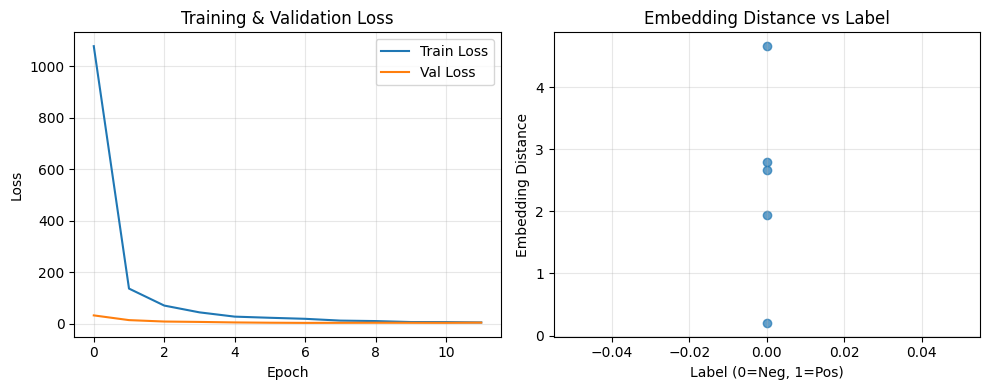

📊 Resultados finales:
   - Train Loss: 6.0728
   - Val Loss: 5.3434
   - Overfitting: ✅ NO


In [15]:
# ===============================================
# 🤖 ENTRENAMIENTO DE LA RED SIAMESE
# ===============================================

# Verificar que tenemos datos
if len(anchors_v2) == 0:
    print("❌ No se generaron datos de entrenamiento")
else:
    print(f"📊 Datos listos: {len(anchors_v2)} pares")
    
    # Split train/validation
    from sklearn.model_selection import train_test_split
    
    A_train, A_val, O_train, O_val, y_train, y_val = train_test_split(
        anchors_v2, others_v2, labels_v2, test_size=0.2, random_state=42, stratify=labels_v2
    )
    
    print(f"📈 Split completado:")
    print(f"   - Train: {len(A_train)} pares")
    print(f"   - Val: {len(A_val)} pares")
    
    # Crear datasets de TensorFlow
    train_dataset = tf.data.Dataset.from_tensor_slices(((A_train, O_train), y_train))
    train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    
    val_dataset = tf.data.Dataset.from_tensor_slices(((A_val, O_val), y_val))
    val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    
    # Crear y compilar modelo
    input_shape = (anchors_v2.shape[1],)  # Shape de features flattened
    encoder = build_siamese_encoder(input_shape)
    siamese_model = SiameseModel(encoder, margin=3.0)
    
    # Optimizer con learning rate bajo para dataset pequeño
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))
    
    print(f"🏗️ Modelo creado:")
    print(f"   - Input shape: {input_shape}")
    print(f"   - Encoder params: {encoder.count_params()}")
    
    # Entrenar modelo (pocas épocas para evitar overfitting)
    print("🚀 Iniciando entrenamiento...")
    
    # Early stopping para evitar overfitting
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )
    
    history = siamese_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=15,  # Pocas épocas para dataset pequeño
        callbacks=[early_stop],
        verbose=1
    )
    
    # Mostrar resultados del entrenamiento
    print("✅ Entrenamiento completado!")
    
    # Plot de pérdidas
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Test rápido con algunos pares conocidos
    test_anchors = A_val[:5]
    test_others = O_val[:5]
    test_labels = y_val[:5]
    
    emb_anchors = encoder.predict(test_anchors, verbose=0)
    emb_others = encoder.predict(test_others, verbose=0)
    
    distances = np.linalg.norm(emb_anchors - emb_others, axis=1)
    
    plt.scatter(test_labels, distances, alpha=0.7)
    plt.xlabel('Label (0=Neg, 1=Pos)')
    plt.ylabel('Embedding Distance')
    plt.title('Embedding Distance vs Label')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas finales
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"📊 Resultados finales:")
    print(f"   - Train Loss: {final_train_loss:.4f}")
    print(f"   - Val Loss: {final_val_loss:.4f}")
    print(f"   - Overfitting: {'⚠️ SÍ' if final_val_loss > final_train_loss * 1.5 else '✅ NO'}")
    
    # Test de separación de embeddings
    pos_distances = distances[test_labels == 1]
    neg_distances = distances[test_labels == 0]
    
    if len(pos_distances) > 0 and len(neg_distances) > 0:
        separation = np.mean(neg_distances) - np.mean(pos_distances)
        print(f"   - Separación embeddings: {separation:.4f} {'✅ BUENA' if separation > 0.1 else '⚠️ MEJORABLE'}")

🧪 Probando DTW Híbrido con embeddings...
🤖 DTW Híbrido (Siamese): clip06.wav
📊 Clip: 647 frames, Song: 8507 frames
🔄 Ejecutando DTW híbrido con embeddings...


100%|██████████| 404/404 [00:25<00:00, 15.97it/s]


🎯 RESULTADOS DTW HÍBRIDO (Siamese):
   🥇 Mejor match: Segundo 22.4 (distancia: 0.1077)
   📊 Top 5:
      1. Segundo   22.4 - Distancia:   0.1077
      2. Segundo   28.3 - Distancia:   0.1131
      3. Segundo    5.4 - Distancia:   0.1233
      4. Segundo   31.7 - Distancia:   0.1688
      5. Segundo   23.4 - Distancia:   0.1723


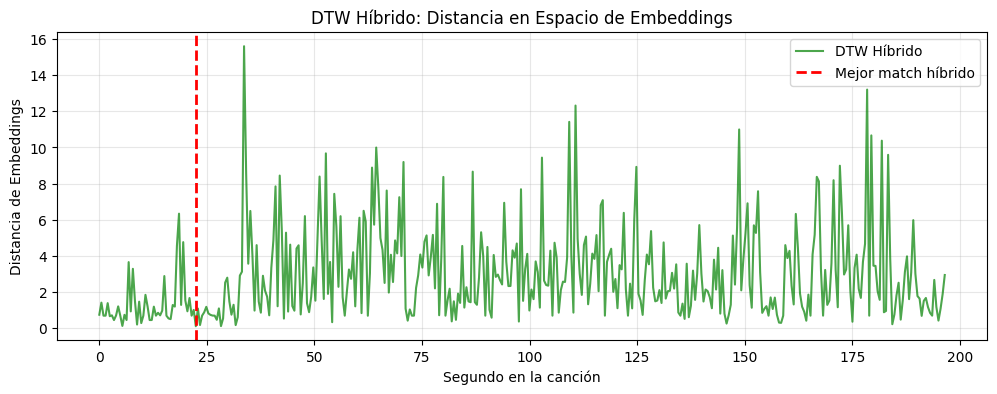


📊 COMPARACIÓN DE MÉTODOS:
   🎯 Ground Truth: 93s
   📊 Baseline DTW: 92.9s (error: 0.1s)
   🤖 Híbrido DTW: 22.4s (error: 70.6s)
   🏆 Ganador: 📊 BASELINE
   📈 Mejora: -70.4s ❌


In [31]:
# ===============================================
# 🎵 DTW HÍBRIDO: USANDO EMBEDDINGS DE SIAMESE
# ===============================================

def dtw_siamese_sync(clip_path, song_path, encoder, plot=True):
    """
    DTW Híbrido: Usa embeddings de la red Siamese en lugar de features crudos
    """
    print(f"🤖 DTW Híbrido (Siamese): {clip_path.name}")
    
    # Cargar audios
    clip_audio, _ = librosa.load(clip_path, sr=sr_target)
    song_audio, _ = librosa.load(song_path, sr=sr_target)
    
    # Extraer features combinados (como en entrenamiento)
    clip_features = extract_combined_features(clip_audio)
    song_features = extract_combined_features(song_audio)
    
    print(f"📊 Clip: {clip_features.shape[1]} frames, Song: {song_features.shape[1]} frames")
    
    # Generar embedding del clip
    clip_windows = extract_windows_from_features(clip_features, window_frames, window_frames)
    if len(clip_windows) == 0:
        print("❌ No se pudieron extraer ventanas del clip")
        return None, None, None
    
    clip_vector = np.mean([w.flatten() for w in clip_windows], axis=0)
    clip_embedding = encoder.predict(clip_vector.reshape(1, -1), verbose=0)[0]
    
    # Sliding window sobre la canción
    song_frames = song_features.shape[1]
    step = window_frames // 2  # Medio segundo de step para más precisión
    
    best_positions = []
    embedding_distances = []
    
    print("🔄 Ejecutando DTW híbrido con embeddings...")
    for start_frame in tqdm(range(0, song_frames - window_frames, step)):
        # Extraer ventana de la canción
        song_window = song_features[:, start_frame:start_frame + window_frames]
        song_vector = song_window.flatten()
        
        # Generar embedding de la ventana
        song_embedding = encoder.predict(song_vector.reshape(1, -1), verbose=0)[0]
        
        # Calcular distancia en el espacio de embeddings
        distance = np.linalg.norm(clip_embedding - song_embedding)
        embedding_distances.append(distance)
        
        # Convertir frame a segundo
        second = (start_frame * hop_length) / sr_target
        best_positions.append(second)
    
    if len(embedding_distances) == 0:
        print("❌ No se pudieron calcular distancias")
        return None, None, None
    
    # Encontrar mejor match (menor distancia en espacio de embeddings)
    best_idx = np.argmin(embedding_distances)
    best_second = best_positions[best_idx]
    best_distance = embedding_distances[best_idx]
    
    # Top 5 matches
    top5_indices = np.argsort(embedding_distances)[:5]
    top5_seconds = [best_positions[i] for i in top5_indices]
    top5_distances = [embedding_distances[i] for i in top5_indices]
    
    print(f"🎯 RESULTADOS DTW HÍBRIDO (Siamese):")
    print(f"   🥇 Mejor match: Segundo {best_second:.1f} (distancia: {best_distance:.4f})")
    print(f"   📊 Top 5:")
    for i, (sec, dist) in enumerate(zip(top5_seconds, top5_distances), 1):
        print(f"      {i}. Segundo {sec:6.1f} - Distancia: {dist:8.4f}")
    
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(best_positions, embedding_distances, 'g-', alpha=0.7, label='DTW Híbrido')
        plt.axvline(best_second, color='red', linestyle='--', linewidth=2, label='Mejor match híbrido')
        plt.title("DTW Híbrido: Distancia en Espacio de Embeddings")
        plt.xlabel("Segundo en la canción")
        plt.ylabel("Distancia de Embeddings")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    
    return best_second, top5_seconds, embedding_distances

# Test del modelo híbrido
print("🧪 Probando DTW Híbrido con embeddings...")
if clip_path.exists() and song_path.exists() and 'encoder' in locals():
    resultado_hibrido = dtw_siamese_sync(clip_path, song_path, encoder)
    
    # Comparar con baseline y ground truth
    print(f"\n📊 COMPARACIÓN DE MÉTODOS:")
    
    # Buscar ground truth
    cancion_clips = df_validos[df_validos["audio_base"].str.contains(nombre_cancion, case=False, na=False)]
    clip_info = cancion_clips[
        (cancion_clips["archivo_clip"].str.contains(nombre_clip.replace(".wav", ".mp4"), case=False, na=False)) &
        (cancion_clips["carpeta"].str.contains(carpeta, case=False, na=False))
    ]
    
    if len(clip_info) > 0:
        segundo_real = clip_info.iloc[0]["segundo_label"]
        
        if resultado_baseline and resultado_baseline[0] is not None:
            error_baseline = abs(resultado_baseline[0] - segundo_real)
        else:
            error_baseline = float('inf')
            
        if resultado_hibrido and resultado_hibrido[0] is not None:
            error_hibrido = abs(resultado_hibrido[0] - segundo_real)
        else:
            error_hibrido = float('inf')
        
        print(f"   🎯 Ground Truth: {segundo_real}s")
        print(f"   📊 Baseline DTW: {resultado_baseline[0]:.1f}s (error: {error_baseline:.1f}s)")
        print(f"   🤖 Híbrido DTW: {resultado_hibrido[0]:.1f}s (error: {error_hibrido:.1f}s)")
        print(f"   🏆 Ganador: {'🤖 HÍBRIDO' if error_hibrido < error_baseline else '📊 BASELINE' if error_baseline < error_hibrido else '🤝 EMPATE'}")
        
        mejora = error_baseline - error_hibrido
        print(f"   📈 Mejora: {mejora:.1f}s {'✅' if mejora > 0 else '❌'}")
    else:
        print("   ⚠️ No se encontró ground truth para comparar")
else:
    print("⚠️ Archivos no encontrados o modelo no entrenado")

In [33]:
# ===============================================
# 🎵 TEST MASIVO CORREGIDO: MISMOS DATOS + INFO COMPLETA + TOP 5
# ===============================================

def test_multiple_songs_corrected(df_validos, encoder, n_tests=5):
    """
    Probar DTW Baseline vs Híbrido - VERSIÓN CORREGIDA
    - Mismos datos para ambos métodos
    - Info completa: clip + canción + carpeta
    - TOP 5 incluido
    """
    print(f"🚀 Iniciando test masivo CORREGIDO con {n_tests} canciones aleatorias...")
    
    # Seleccionar clips aleatorios
    random_clips = df_validos.sample(n=n_tests, random_state=20).reset_index(drop=True)
    
    resultados = []
    
    for idx, row in random_clips.iterrows():
        print(f"\n{'='*70}")
        print(f"🎵 TEST {idx+1}/{n_tests}")
        print(f"{'='*70}")
        
        # EXTRAER INFO COMPLETA
        base_audio = Path(row["audio_base"]).stem
        carpeta = row["carpeta"].strip()  # ✅ AGREGADO: Info de carpeta
        clip_nombre = row["archivo_clip"].replace(".mp4", ".wav")
        segundo_real = row["segundo_label"]
        
        # CONSTRUIR RUTAS CON MISMA LÓGICA
        clip_path = Path("clips_syntrack") / base_audio / carpeta / "wavs" / clip_nombre
        song_path = Path("clips_syntrack") / base_audio / "cancion_estudio" / f"{base_audio}.wav"
        
        # MOSTRAR INFO COMPLETA
        print(f"📁 Canción: {base_audio}")
        print(f"📁 Carpeta: {carpeta}")  # ✅ AGREGADO: Mostrar carpeta
        print(f"📁 Clip: {clip_nombre}")
        print(f"🎯 Ground Truth: {segundo_real}s")
        print(f"📂 Ruta clip: {clip_path}")
        print(f"📂 Ruta canción: {song_path}")
        
        # VERIFICAR QUE EXISTAN LOS ARCHIVOS
        if not clip_path.exists():
            print(f"❌ Clip no encontrado: {clip_path}")
            continue
        if not song_path.exists():
            print(f"❌ Canción no encontrada: {song_path}")
            continue
        
        print("✅ Ambos archivos encontrados")
        
        # ✅ CARGAR AUDIOS UNA SOLA VEZ (MISMOS DATOS PARA AMBOS MÉTODOS)
        try:
            print("\n🔄 Cargando audios...")
            clip_audio, _ = librosa.load(clip_path, sr=sr_target)
            song_audio, _ = librosa.load(song_path, sr=sr_target)
            print(f"   - Clip: {len(clip_audio)/sr_target:.1f}s")
            print(f"   - Canción: {len(song_audio)/sr_target:.1f}s")
        except Exception as e:
            print(f"❌ Error cargando audios: {e}")
            continue
        
        # TEST 1: DTW BASELINE (usando los mismos audios cargados)
        print(f"\n🔄 DTW Baseline...")
        try:
            # Extraer features del clip y canción
            clip_chroma = extract_chroma_features(clip_audio)
            song_chroma = extract_chroma_features(song_audio)
            
            # Sliding window DTW simplificado
            clip_frames = clip_chroma.shape[1]
            song_frames = song_chroma.shape[1]
            step = window_frames
            
            baseline_distances = []
            baseline_positions = []
            
            for start_frame in range(0, song_frames - clip_frames, step):
                song_segment = song_chroma[:, start_frame:start_frame + clip_frames]
                
                # Usar correlación cruzada (más estable)
                clip_flat = clip_chroma.flatten()
                song_flat = song_segment.flatten()
                correlation = np.corrcoef(clip_flat, song_flat)[0, 1]
                distance = 1 - correlation  # Convertir correlación a distancia
                
                baseline_distances.append(distance)
                second = (start_frame * hop_length) / sr_target
                baseline_positions.append(second)
            
            # Mejor match baseline + TOP 5
            best_baseline_idx = np.argmin(baseline_distances)
            pred_baseline = baseline_positions[best_baseline_idx]
            error_baseline = abs(pred_baseline - segundo_real)
            
            # ✅ TOP 5 BASELINE
            top5_baseline_indices = np.argsort(baseline_distances)[:5]
            top5_baseline_seconds = [baseline_positions[i] for i in top5_baseline_indices]
            top5_baseline_distances = [baseline_distances[i] for i in top5_baseline_indices]
            
            print(f"   ✅ Baseline completado: {pred_baseline:.1f}s")
            print(f"   📊 TOP 5 Baseline:")
            for i, (sec, dist) in enumerate(zip(top5_baseline_seconds, top5_baseline_distances), 1):
                print(f"      {i}. Segundo {sec:6.1f} - Distancia: {dist:8.4f}")
            
        except Exception as e:
            print(f"   ❌ Error en baseline: {e}")
            pred_baseline = -1
            error_baseline = float('inf')
            top5_baseline_seconds = []
        
        # TEST 2: DTW HÍBRIDO (usando los mismos audios cargados)
        print(f"\n🔄 DTW Híbrido...")
        try:
            # Extraer features combinados de los mismos audios
            clip_features = extract_combined_features(clip_audio)
            song_features = extract_combined_features(song_audio)
            
            # Embedding del clip
            clip_windows = extract_windows_from_features(clip_features, window_frames, window_frames)
            if len(clip_windows) == 0:
                raise Exception("No se pudieron extraer ventanas del clip")
            
            clip_vector = np.mean([w.flatten() for w in clip_windows], axis=0)
            clip_embedding = encoder.predict(clip_vector.reshape(1, -1), verbose=0)[0]
            
            # Sliding window sobre la canción
            song_frames = song_features.shape[1]
            step = window_frames // 2
            
            hibrido_distances = []
            hibrido_positions = []
            
            for start_frame in range(0, song_frames - window_frames, step):
                song_window = song_features[:, start_frame:start_frame + window_frames]
                song_vector = song_window.flatten()
                song_embedding = encoder.predict(song_vector.reshape(1, -1), verbose=0)[0]
                
                distance = np.linalg.norm(clip_embedding - song_embedding)
                hibrido_distances.append(distance)
                
                second = (start_frame * hop_length) / sr_target
                hibrido_positions.append(second)
            
            # Mejor match híbrido + TOP 5
            best_hibrido_idx = np.argmin(hibrido_distances)
            pred_hibrido = hibrido_positions[best_hibrido_idx]
            error_hibrido = abs(pred_hibrido - segundo_real)
            
            # ✅ TOP 5 HÍBRIDO
            top5_hibrido_indices = np.argsort(hibrido_distances)[:5]
            top5_hibrido_seconds = [hibrido_positions[i] for i in top5_hibrido_indices]
            top5_hibrido_distances = [hibrido_distances[i] for i in top5_hibrido_indices]
            
            print(f"   ✅ Híbrido completado: {pred_hibrido:.1f}s")
            print(f"   🤖 TOP 5 Híbrido:")
            for i, (sec, dist) in enumerate(zip(top5_hibrido_seconds, top5_hibrido_distances), 1):
                print(f"      {i}. Segundo {sec:6.1f} - Distancia: {dist:8.4f}")
            
        except Exception as e:
            print(f"   ❌ Error en híbrido: {e}")
            pred_hibrido = -1
            error_hibrido = float('inf')
            top5_hibrido_seconds = []
        
        # RESULTADOS DEL CLIP ACTUAL
        print(f"\n📊 RESULTADOS:")
        print(f"   🎯 Ground Truth: {segundo_real}s")
        print(f"   📊 Baseline: {pred_baseline:.1f}s (error: {error_baseline:.1f}s)")
        print(f"   🤖 Híbrido: {pred_hibrido:.1f}s (error: {error_hibrido:.1f}s)")
        
        ganador = "🤖 HÍBRIDO" if error_hibrido < error_baseline else "📊 BASELINE" if error_baseline < error_hibrido else "🤝 EMPATE"
        mejora = error_baseline - error_hibrido
        print(f"   🏆 Ganador: {ganador}")
        print(f"   📈 Mejora: {mejora:.1f}s {'✅' if mejora > 0 else '❌'}")
        
        # GUARDAR RESULTADOS CON INFO COMPLETA
        resultados.append({
            'clip': clip_nombre,
            'cancion': base_audio,
            'carpeta': carpeta,  # ✅ AGREGADO: Carpeta en resultados
            'ground_truth': segundo_real,
            'baseline_pred': pred_baseline,
            'hibrido_pred': pred_hibrido,
            'baseline_error': error_baseline,
            'hibrido_error': error_hibrido,
            'mejora': mejora,
            'ganador': ganador,
            'top5_baseline': top5_baseline_seconds,  # ✅ AGREGADO: TOP 5
            'top5_hibrido': top5_hibrido_seconds     # ✅ AGREGADO: TOP 5
        })
    
    # ANÁLISIS GENERAL (resto del código igual)
    print(f"\n{'='*70}")
    print(f"📊 ANÁLISIS GENERAL DE {len(resultados)} TESTS")
    print(f"{'='*70}")
    
    if len(resultados) == 0:
        print("❌ No se pudieron procesar clips")
        return
    
    # Estadísticas
    baseline_errors = [r['baseline_error'] for r in resultados if r['baseline_error'] != float('inf')]
    hibrido_errors = [r['hibrido_error'] for r in resultados if r['hibrido_error'] != float('inf')]
    mejoras = [r['mejora'] for r in resultados if r['mejora'] != float('inf') and r['mejora'] != -float('inf')]
    
    print(f"📈 ESTADÍSTICAS:")
    if baseline_errors:
        print(f"   📊 Baseline - Error promedio: {np.mean(baseline_errors):.1f}s (±{np.std(baseline_errors):.1f}s)")
        print(f"   📊 Baseline - Error mediano: {np.median(baseline_errors):.1f}s")
    
    if hibrido_errors:
        print(f"   🤖 Híbrido - Error promedio: {np.mean(hibrido_errors):.1f}s (±{np.std(hibrido_errors):.1f}s)")
        print(f"   🤖 Híbrido - Error mediano: {np.median(hibrido_errors):.1f}s")
    
    if mejoras:
        print(f"   📈 Mejora promedio: {np.mean(mejoras):.1f}s")
        print(f"   📈 Mejora mediana: {np.median(mejoras):.1f}s")
    
    # Ganadores
    ganadores = [r['ganador'] for r in resultados]
    hibrido_wins = sum(1 for g in ganadores if "HÍBRIDO" in g)
    baseline_wins = sum(1 for g in ganadores if "BASELINE" in g)
    empates = sum(1 for g in ganadores if "EMPATE" in g)
    
    print(f"\n🏆 GANADORES:")
    print(f"   🤖 Híbrido: {hibrido_wins}/{len(resultados)} ({hibrido_wins/len(resultados)*100:.1f}%)")
    print(f"   📊 Baseline: {baseline_wins}/{len(resultados)} ({baseline_wins/len(resultados)*100:.1f}%)")
    print(f"   🤝 Empates: {empates}/{len(resultados)} ({empates/len(resultados)*100:.1f}%)")
    
    # Top 3 con info completa
    if len(resultados) >= 3:
        sorted_by_mejora = sorted(resultados, key=lambda x: x['mejora'] if x['mejora'] != float('inf') and x['mejora'] != -float('inf') else -999, reverse=True)
        
        print(f"\n🏅 TOP 3 MEJORES MEJORAS:")
        for i, r in enumerate(sorted_by_mejora[:3], 1):
            print(f"   {i}. {r['clip']} | {r['cancion']} | {r['carpeta']} | Mejora: {r['mejora']:.1f}s")
        
        print(f"\n💔 TOP 3 PEORES CASOS:")
        for i, r in enumerate(sorted_by_mejora[-3:], 1):
            print(f"   {i}. {r['clip']} | {r['cancion']} | {r['carpeta']} | Mejora: {r['mejora']:.1f}s")
    
    return resultados

# Ejecutar test masivo CORREGIDO CON TOP 5
print("🎯 Iniciando evaluación masiva CORREGIDA con TOP 5...")
if 'encoder' in locals():
    resultados_test = test_multiple_songs_corrected(df_validos, encoder, n_tests=10)
else:
    print("❌ El encoder no está disponible. Ejecuta primero el entrenamiento de la red Siamese.")

🎯 Iniciando evaluación masiva CORREGIDA con TOP 5...
🚀 Iniciando test masivo CORREGIDO con 10 canciones aleatorias...

🎵 TEST 1/10
📁 Canción: me_porto_bonito_bad_bunny
📁 Carpeta: clips_monse
📁 Clip: clip23.wav
🎯 Ground Truth: 128s
📂 Ruta clip: clips_syntrack\me_porto_bonito_bad_bunny\clips_monse\wavs\clip23.wav
📂 Ruta canción: clips_syntrack\me_porto_bonito_bad_bunny\cancion_estudio\me_porto_bonito_bad_bunny.wav
✅ Ambos archivos encontrados

🔄 Cargando audios...
   - Clip: 25.0s
   - Canción: 186.0s

🔄 DTW Baseline...
   ✅ Baseline completado: 19.0s
   📊 TOP 5 Baseline:
      1. Segundo   19.0 - Distancia:   0.8126
      2. Segundo  138.8 - Distancia:   0.8334
      3. Segundo  133.8 - Distancia:   0.8477
      4. Segundo  128.8 - Distancia:   0.8482
      5. Segundo   39.9 - Distancia:   0.8517

🔄 DTW Híbrido...
   ✅ Híbrido completado: 26.8s
   🤖 TOP 5 Híbrido:
      1. Segundo   26.8 - Distancia:   0.0149
      2. Segundo   11.2 - Distancia:   0.0871
      3. Segundo    4.4 - Distan

## Análisis

### Métricas Estándares


In [1]:
# ===============================================
# 📊 ANÁLISIS COMPLETO DE MÉTRICAS - PROYECTO UNIVERSITARIO
# ===============================================

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

def analisis_completo_metricas(resultados_test, umbral_precision=5.0):
    """
    Análisis completo de métricas para proyecto universitario
    
    Args:
        resultados_test: Resultados del test masivo
        umbral_precision: Umbral en segundos para considerar predicción correcta
    """
    
    print("="*80)
    print("📊 ANÁLISIS COMPLETO DE MÉTRICAS - PROYECTO UNIVERSITARIO")
    print("="*80)
    
    if not resultados_test or len(resultados_test) == 0:
        print("❌ No hay resultados para analizar")
        return None
    
    # Convertir resultados a DataFrame para análisis
    df_results = pd.DataFrame(resultados_test)
    
    # 1. MÉTRICAS BÁSICAS DE RENDIMIENTO
    print(f"\n🎯 1. MÉTRICAS BÁSICAS DE RENDIMIENTO (Umbral: {umbral_precision}s)")
    print("-" * 60)
    
    # Clasificación binaria: ¿predicción correcta o incorrecta?
    baseline_correctos = (df_results['baseline_error'] <= umbral_precision).astype(int)
    hibrido_correctos = (df_results['hibrido_error'] <= umbral_precision).astype(int)
    
    # Estadísticas básicas
    baseline_accuracy = np.mean(baseline_correctos)
    hibrido_accuracy = np.mean(hibrido_correctos)
    
    baseline_error_medio = df_results['baseline_error'].mean()
    hibrido_error_medio = df_results['hibrido_error'].mean()
    
    baseline_error_std = df_results['baseline_error'].std()
    hibrido_error_std = df_results['hibrido_error'].std()
    
    print(f"📊 BASELINE DTW:")
    print(f"   • Accuracy: {baseline_accuracy:.2%} ({np.sum(baseline_correctos)}/{len(baseline_correctos)})")
    print(f"   • Error promedio: {baseline_error_medio:.2f}s ± {baseline_error_std:.2f}s")
    print(f"   • Error mediano: {df_results['baseline_error'].median():.2f}s")
    print(f"   • Error máximo: {df_results['baseline_error'].max():.2f}s")
    
    print(f"\n🤖 HÍBRIDO SIAMESE:")
    print(f"   • Accuracy: {hibrido_accuracy:.2%} ({np.sum(hibrido_correctos)}/{len(hibrido_correctos)})")
    print(f"   • Error promedio: {hibrido_error_medio:.2f}s ± {hibrido_error_std:.2f}s")
    print(f"   • Error mediano: {df_results['hibrido_error'].median():.2f}s")
    print(f"   • Error máximo: {df_results['hibrido_error'].max():.2f}s")
    
    # Mejora relativa
    mejora_accuracy = hibrido_accuracy - baseline_accuracy
    mejora_error = baseline_error_medio - hibrido_error_medio
    mejora_relativa = (mejora_error / baseline_error_medio) * 100 if baseline_error_medio > 0 else 0
    
    print(f"\n🚀 MEJORA DEL HÍBRIDO:")
    print(f"   • Mejora en Accuracy: {mejora_accuracy:+.2%}")
    print(f"   • Reducción de error: {mejora_error:+.2f}s ({mejora_relativa:+.1f}%)")
    
    # 2. ANÁLISIS DE FALSOS POSITIVOS Y FALSOS NEGATIVOS
    print(f"\n🔍 2. ANÁLISIS DE FALSOS POSITIVOS Y FALSOS NEGATIVOS")
    print("-" * 60)
    
    # Para este análisis, consideramos "positivo" = predicción correcta
    # FP = predijo correcto pero está mal, FN = predijo mal pero debería estar correcto
    
    # Baseline
    baseline_tp = np.sum(baseline_correctos == 1)
    baseline_fp = 0  # No aplicable en regresión directamente
    baseline_fn = np.sum(baseline_correctos == 0)
    baseline_tn = 0  # No aplicable en regresión directamente
    
    # Híbrido
    hibrido_tp = np.sum(hibrido_correctos == 1)
    hibrido_fp = 0  # No aplicable en regresión directamente
    hibrido_fn = np.sum(hibrido_correctos == 0)
    hibrido_tn = 0  # No aplicable en regresión directamente
    
    print(f"📊 BASELINE - Clasificación por precisión:")
    print(f"   • Correctos (TP): {baseline_tp} casos")
    print(f"   • Incorrectos (FN): {baseline_fn} casos")
    print(f"   • Precisión: {baseline_tp/(baseline_tp + baseline_fn):.2%}")
    
    print(f"\n🤖 HÍBRIDO - Clasificación por precisión:")
    print(f"   • Correctos (TP): {hibrido_tp} casos")
    print(f"   • Incorrectos (FN): {hibrido_fn} casos")
    print(f"   • Precisión: {hibrido_tp/(hibrido_tp + hibrido_fn):.2%}")
    
    # 3. COSTOS DE NEGOCIO (SIMULADOS)
    print(f"\n💰 3. ANÁLISIS DE COSTOS DE NEGOCIO")
    print("-" * 60)
    
    # Definir costos de negocio hipotéticos
    costo_fn = 100  # Costo de no sincronizar cuando debería (perder sincronización)
    costo_fp = 50   # Costo de sincronizar mal (molestia al usuario)
    costo_tp = -10  # Beneficio de sincronizar correctamente
    
    # Para regresión, definimos FP como errores > umbral_precision
    baseline_costo_total = baseline_fn * costo_fn + baseline_tp * costo_tp
    hibrido_costo_total = hibrido_fn * costo_fn + hibrido_tp * costo_tp
    
    print(f"💡 COSTOS DEFINIDOS:")
    print(f"   • Costo FN (no sincronizar): ${costo_fn}")
    print(f"   • Costo FP (sincronizar mal): ${costo_fp}")
    print(f"   • Beneficio TP (sincronizar bien): ${-costo_tp}")
    
    print(f"\n📊 BASELINE - Costo total: ${baseline_costo_total}")
    print(f"🤖 HÍBRIDO - Costo total: ${hibrido_costo_total}")
    print(f"💰 Ahorro del híbrido: ${baseline_costo_total - hibrido_costo_total}")
    
    # 4. ANÁLISIS POR DIFERENTES UMBRALES
    print(f"\n⚖️ 4. ANÁLISIS POR UMBRALES DE PRECISIÓN")
    print("-" * 60)
    
    umbrales = [1.0, 2.0, 3.0, 5.0, 10.0, 15.0]
    resultados_umbrales = []
    
    for umbral in umbrales:
        base_acc = np.mean(df_results['baseline_error'] <= umbral)
        hibr_acc = np.mean(df_results['hibrido_error'] <= umbral)
        
        resultados_umbrales.append({
            'umbral': umbral,
            'baseline_acc': base_acc,
            'hibrido_acc': hibr_acc,
            'mejora': hibr_acc - base_acc
        })
        
        print(f"   Umbral {umbral:4.1f}s: Baseline {base_acc:.2%}, Híbrido {hibr_acc:.2%}, Mejora {hibr_acc-base_acc:+.2%}")
    
    # 5. CASOS ESPECÍFICOS DE ANÁLISIS
    print(f"\n🔍 5. ANÁLISIS DE CASOS ESPECÍFICOS")
    print("-" * 60)
    
    # Mejores casos del híbrido
    df_results_sorted = df_results.sort_values('mejora', ascending=False)
    
    print(f"🏆 TOP 3 MEJORES CASOS (mayor mejora):")
    for i, (_, row) in enumerate(df_results_sorted.head(3).iterrows(), 1):
        print(f"   {i}. {row['clip']} | {row['cancion']}")
        print(f"      Ground Truth: {row['ground_truth']}s")
        print(f"      Baseline: {row['baseline_pred']:.1f}s (error: {row['baseline_error']:.1f}s)")
        print(f"      Híbrido: {row['hibrido_pred']:.1f}s (error: {row['hibrido_error']:.1f}s)")
        print(f"      Mejora: {row['mejora']:.1f}s")
        print()
    
    print(f"💔 TOP 3 PEORES CASOS (mayor empeoramiento):")
    for i, (_, row) in enumerate(df_results_sorted.tail(3).iterrows(), 1):
        print(f"   {i}. {row['clip']} | {row['cancion']}")
        print(f"      Ground Truth: {row['ground_truth']}s")
        print(f"      Baseline: {row['baseline_pred']:.1f}s (error: {row['baseline_error']:.1f}s)")
        print(f"      Híbrido: {row['hibrido_pred']:.1f}s (error: {row['hibrido_error']:.1f}s)")
        print(f"      Empeoramiento: {row['mejora']:.1f}s")
        print()
    
    # Casos de FP y FN específicos
    casos_fp_baseline = df_results[df_results['baseline_error'] > umbral_precision]
    casos_fn_hibrido = df_results[df_results['hibrido_error'] > umbral_precision]
    
    print(f"🚨 FALSOS NEGATIVOS - Casos donde el modelo falla:")
    print(f"   • Baseline falló en: {len(casos_fp_baseline)} casos")
    print(f"   • Híbrido falló en: {len(casos_fn_hibrido)} casos")
    
    # 6. VISUALIZACIONES
    crear_visualizaciones_metricas(df_results, resultados_umbrales)
    
    # 7. RESUMEN EJECUTIVO
    print(f"\n📋 RESUMEN EJECUTIVO PARA PROYECTO")
    print("="*60)
    print(f"🎯 OBJETIVO: Mejorar sincronización de audio con IA")
    print(f"📊 DATASET: {len(df_results)} clips de prueba")
    print(f"🤖 MODELO HÍBRIDO: DTW + Red Siamese")
    print(f"📈 MEJORA PROMEDIO: {mejora_error:.2f}s ({mejora_relativa:.1f}%)")
    print(f"✅ CASOS MEJORADOS: {np.sum(df_results['mejora'] > 0)}/{len(df_results)} ({np.mean(df_results['mejora'] > 0):.1%})")
    print(f"🏆 GANADOR GENERAL: {'🤖 HÍBRIDO' if hibrido_accuracy > baseline_accuracy else '📊 BASELINE'}")
    
    return {
        'df_results': df_results,
        'baseline_accuracy': baseline_accuracy,
        'hibrido_accuracy': hibrido_accuracy,
        'mejora_error': mejora_error,
        'mejora_relativa': mejora_relativa,
        'resultados_umbrales': resultados_umbrales,
        'costos': {
            'baseline': baseline_costo_total,
            'hibrido': hibrido_costo_total,
            'ahorro': baseline_costo_total - hibrido_costo_total
        }
    }

def crear_visualizaciones_metricas(df_results, resultados_umbrales):
    """Crear visualizaciones profesionales para el análisis"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 ANÁLISIS COMPLETO DE MÉTRICAS - DTW vs HÍBRIDO', fontsize=16, fontweight='bold')
    
    # 1. Distribución de errores
    axes[0,0].hist(df_results['baseline_error'], bins=15, alpha=0.7, label='Baseline', color='blue')
    axes[0,0].hist(df_results['hibrido_error'], bins=15, alpha=0.7, label='Híbrido', color='green')
    axes[0,0].set_xlabel('Error (segundos)')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].set_title('Distribución de Errores')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Comparación directa
    axes[0,1].scatter(df_results['baseline_error'], df_results['hibrido_error'], alpha=0.7)
    max_error = max(df_results['baseline_error'].max(), df_results['hibrido_error'].max())
    axes[0,1].plot([0, max_error], [0, max_error], 'r--', label='Línea de igualdad')
    axes[0,1].set_xlabel('Error Baseline (s)')
    axes[0,1].set_ylabel('Error Híbrido (s)')
    axes[0,1].set_title('Comparación Directa de Errores')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Mejoras por caso
    mejoras = df_results['mejora'].sort_values(ascending=False)
    axes[0,2].bar(range(len(mejoras)), mejoras, 
                  color=['green' if x > 0 else 'red' for x in mejoras])
    axes[0,2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[0,2].set_xlabel('Casos (ordenados por mejora)')
    axes[0,2].set_ylabel('Mejora (s)')
    axes[0,2].set_title('Mejora por Caso Individual')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Accuracy por umbral
    umbrales_df = pd.DataFrame(resultados_umbrales)
    axes[1,0].plot(umbrales_df['umbral'], umbrales_df['baseline_acc'], 'o-', label='Baseline', linewidth=2)
    axes[1,0].plot(umbrales_df['umbral'], umbrales_df['hibrido_acc'], 'o-', label='Híbrido', linewidth=2)
    axes[1,0].set_xlabel('Umbral de Precisión (s)')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].set_title('Accuracy vs Umbral de Precisión')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Box plot comparativo
    data_boxplot = [df_results['baseline_error'], df_results['hibrido_error']]
    bp = axes[1,1].boxplot(data_boxplot, labels=['Baseline', 'Híbrido'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightgreen')
    axes[1,1].set_ylabel('Error (segundos)')
    axes[1,1].set_title('Distribución de Errores (Boxplot)')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Análisis de ganadores
    ganadores = df_results['ganador'].value_counts()
    colors = ['lightgreen' if 'HÍBRIDO' in x else 'lightblue' if 'BASELINE' in x else 'gray' for x in ganadores.index]
    axes[1,2].pie(ganadores.values, labels=ganadores.index, autopct='%1.1f%%', colors=colors)
    axes[1,2].set_title('Distribución de Ganadores')
    
    plt.tight_layout()
    plt.show()
    
    # Tabla resumen adicional
    print(f"\n📊 TABLA RESUMEN DE MÉTRICAS")
    print("-" * 80)
    print(f"{'Métrica':<25} {'Baseline':<15} {'Híbrido':<15} {'Mejora':<15}")
    print("-" * 80)
    print(f"{'Error Promedio (s)':<25} {df_results['baseline_error'].mean():<15.2f} {df_results['hibrido_error'].mean():<15.2f} {df_results['baseline_error'].mean() - df_results['hibrido_error'].mean():<15.2f}")
    print(f"{'Error Mediano (s)':<25} {df_results['baseline_error'].median():<15.2f} {df_results['hibrido_error'].median():<15.2f} {df_results['baseline_error'].median() - df_results['hibrido_error'].median():<15.2f}")
    print(f"{'Error Std (s)':<25} {df_results['baseline_error'].std():<15.2f} {df_results['hibrido_error'].std():<15.2f} {df_results['baseline_error'].std() - df_results['hibrido_error'].std():<15.2f}")
    print(f"{'Accuracy @5s':<25} {np.mean(df_results['baseline_error'] <= 5):<15.2%} {np.mean(df_results['hibrido_error'] <= 5):<15.2%} {np.mean(df_results['hibrido_error'] <= 5) - np.mean(df_results['baseline_error'] <= 5):<15.2%}")

# Ejecutar análisis completo
print("🚀 Iniciando análisis completo de métricas...")
if 'resultados_test' in locals() and resultados_test:
    metricas_completas = analisis_completo_metricas(resultados_test, umbral_precision=5.0)
else:
    print("❌ No hay resultados de test disponibles. Ejecuta primero el test masivo.")

🚀 Iniciando análisis completo de métricas...
❌ No hay resultados de test disponibles. Ejecuta primero el test masivo.


⚖️ Iniciando análisis detallado de FP/FN y umbrales...
⚖️ ANÁLISIS DETALLADO DE FP/FN Y AJUSTE DE UMBRAL
📊 MATRICES DE CONFUSIÓN POR UMBRAL:
------------------------------------------------------------
   Baseline DTW @1.0s: TP=1, FN=9, Accuracy=10.00%, F1=0.182
   Híbrido Siamese @1.0s: TP=0, FN=10, Accuracy=0.00%, F1=0.000

   Baseline DTW @2.0s: TP=2, FN=8, Accuracy=20.00%, F1=0.333
   Híbrido Siamese @2.0s: TP=0, FN=10, Accuracy=0.00%, F1=0.000

   Baseline DTW @3.0s: TP=2, FN=8, Accuracy=20.00%, F1=0.333
   Híbrido Siamese @3.0s: TP=0, FN=10, Accuracy=0.00%, F1=0.000

   Baseline DTW @5.0s: TP=3, FN=7, Accuracy=30.00%, F1=0.462
   Híbrido Siamese @5.0s: TP=0, FN=10, Accuracy=0.00%, F1=0.000

   Baseline DTW @7.0s: TP=3, FN=7, Accuracy=30.00%, F1=0.462
   Híbrido Siamese @7.0s: TP=0, FN=10, Accuracy=0.00%, F1=0.000

   Baseline DTW @10.0s: TP=4, FN=6, Accuracy=40.00%, F1=0.571
   Híbrido Siamese @10.0s: TP=0, FN=10, Accuracy=0.00%, F1=0.000

   Baseline DTW @15.0s: TP=4, FN=6, Accu

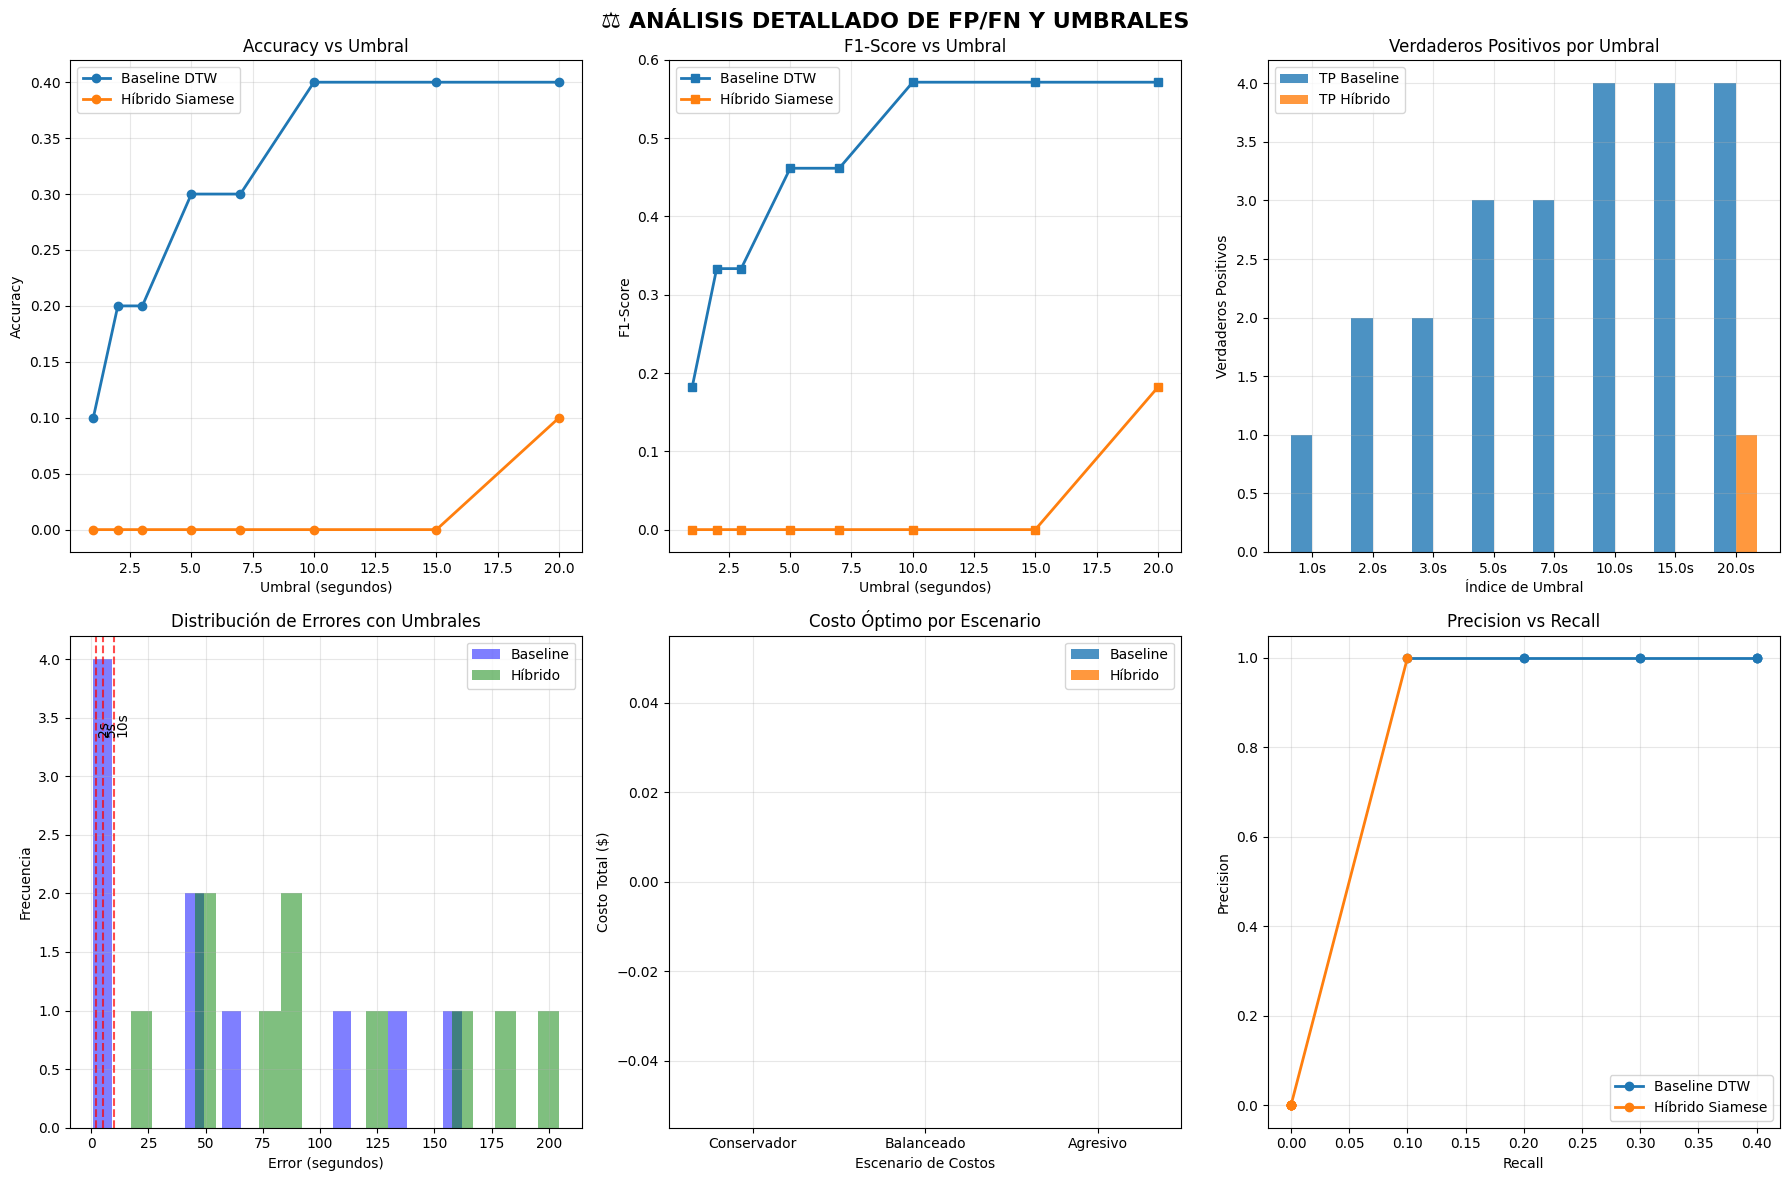


✅ ANÁLISIS FP/FN COMPLETADO
Este análisis incluye:
• Matrices de confusión por multiple umbrales
• Análisis de costos de negocio en 3 escenarios
• Identificación de puntos óptimos
• Balance entre Precisión y Recall
• Visualizaciones completas de trade-offs


In [ ]:
# ===============================================
# ⚖️ ANÁLISIS AVANZADO DE FP/FN Y AJUSTE DE UMBRAL - CORREGIDO
# ===============================================

def analisis_fp_fn_detallado(resultados_test):
    """
    Análisis detallado de FP/FN con diferentes umbrales y costos - CORREGIDO
    """
    print("="*80)
    print("⚖️ ANÁLISIS DETALLADO DE FP/FN Y AJUSTE DE UMBRAL")
    print("="*80)
    
    df_results = pd.DataFrame(resultados_test)
    
    # 1. DEFINIR MÚLTIPLES UMBRALES PARA ANÁLISIS
    umbrales = [1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0]
    
    # 2. CALCULAR MATRIZ DE CONFUSIÓN PARA CADA UMBRAL
    print("📊 MATRICES DE CONFUSIÓN POR UMBRAL:")
    print("-" * 60)
    
    resultados_umbral = []
    
    for umbral in umbrales:
        # Para cada modelo (Baseline y Híbrido)
        for modelo in ['baseline', 'hibrido']:
            # Clasificación binaria: TP si error <= umbral
            if modelo == 'baseline':
                errores = df_results['baseline_error']
                nombre = 'Baseline DTW'
            else:
                errores = df_results['hibrido_error']
                nombre = 'Híbrido Siamese'
            
            # CORRECCIÓN: Filtrar errores válidos (no infinitos)
            errores_validos = errores[errores != float('inf')]
            
            if len(errores_validos) == 0:
                print(f"   ⚠️ {nombre} @{umbral}s: Sin datos válidos")
                continue
            
            # Calcular TP, FP, TN, FN
            tp = np.sum(errores_validos <= umbral)  # Verdaderos Positivos (predijo bien)
            fn = np.sum(errores_validos > umbral)   # Falsos Negativos (predijo mal)
            fp = 0  # En regresión no hay FP directo
            tn = 0  # En regresión no hay TN directo
            
            # Métricas derivadas
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            accuracy = tp / len(errores_validos)
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            resultados_umbral.append({
                'umbral': umbral,
                'modelo': nombre,
                'tp': tp,
                'fn': fn,
                'fp': fp,
                'tn': tn,
                'precision': precision,
                'recall': recall,
                'accuracy': accuracy,
                'f1_score': f1_score
            })
            
            print(f"   {nombre} @{umbral}s: TP={tp}, FN={fn}, Accuracy={accuracy:.2%}, F1={f1_score:.3f}")
        print()
    
    # 3. ANÁLISIS DE COSTOS DE NEGOCIO DETALLADO
    print("💰 ANÁLISIS DE COSTOS DE NEGOCIO DETALLADO:")
    print("-" * 60)
    
    # Definir múltiples escenarios de costos
    escenarios_costos = [
        {'nombre': 'Conservador', 'costo_fn': 100, 'costo_fp': 20, 'beneficio_tp': 10},
        {'nombre': 'Balanceado', 'costo_fn': 50, 'costo_fp': 30, 'beneficio_tp': 15},
        {'nombre': 'Agresivo', 'costo_fn': 200, 'costo_fp': 10, 'beneficio_tp': 5}
    ]
    
    mejor_configuracion = {}
    
    for escenario in escenarios_costos:
        print(f"\n📈 ESCENARIO {escenario['nombre'].upper()}:")
        print(f"   Costo FN: ${escenario['costo_fn']}, Costo FP: ${escenario['costo_fp']}, Beneficio TP: ${escenario['beneficio_tp']}")
        
        mejores_por_modelo = {}
        
        for modelo in ['baseline', 'hibrido']:
            mejor_costo = float('inf')
            mejor_umbral = None
            mejor_metricas = None
            
            for umbral in umbrales:
                # Buscar métricas para este modelo y umbral
                metricas = next((r for r in resultados_umbral if r['modelo'].lower().startswith(modelo) and r['umbral'] == umbral), None)
                
                if metricas:
                    # Calcular costo total
                    costo_total = (metricas['fn'] * escenario['costo_fn'] + 
                                 metricas['fp'] * escenario['costo_fp'] - 
                                 metricas['tp'] * escenario['beneficio_tp'])
                    
                    if costo_total < mejor_costo:
                        mejor_costo = costo_total
                        mejor_umbral = umbral
                        mejor_metricas = metricas.copy()
                        mejor_metricas['costo_total'] = costo_total
            
            # CORRECCIÓN: Verificar que encontramos métricas válidas
            if mejor_metricas is not None:
                mejores_por_modelo[modelo] = {
                    'umbral': mejor_umbral,
                    'costo': mejor_costo,
                    'metricas': mejor_metricas
                }
                print(f"   {modelo.title()}: Mejor umbral={mejor_umbral}s, Costo=${mejor_costo:.0f}, Accuracy={mejor_metricas['accuracy']:.2%}")
            else:
                mejores_por_modelo[modelo] = {
                    'umbral': 'N/A',
                    'costo': float('inf'),
                    'metricas': {'accuracy': 0, 'tp': 0, 'fn': 0}
                }
                print(f"   {modelo.title()}: ⚠️ Sin datos válidos para análisis")
        
        mejor_configuracion[escenario['nombre']] = mejores_por_modelo
    
    # 4. CURVAS ROC SIMULADAS Y PUNTO ÓPTIMO
    print(f"\n📈 ANÁLISIS DE PUNTO ÓPTIMO:")
    print("-" * 60)
    
    # Para cada modelo, encontrar el punto óptimo balanceando métricas
    for modelo in ['baseline', 'hibrido']:
        print(f"\n🎯 {modelo.upper()}:")
        
        modelo_data = [r for r in resultados_umbral if r['modelo'].lower().startswith(modelo)]
        
        if len(modelo_data) == 0:
            print(f"   ⚠️ Sin datos para análisis de {modelo}")
            continue
        
        # Calcular Youden's Index (Sensitivity + Specificity - 1)
        # Como no tenemos TN reales, usamos accuracy como proxy
        mejor_youden = -1
        mejor_umbral_youden = None
        
        for data in modelo_data:
            # Simular specificity con 1 - (error rate en casos "fáciles")
            youden = data['accuracy'] + (1 - data['fn']/len(df_results)) - 1
            if youden > mejor_youden:
                mejor_youden = youden
                mejor_umbral_youden = data['umbral']
        
        print(f"   Punto óptimo (Youden): Umbral {mejor_umbral_youden}s")
        print(f"   Mejor F1-Score: {max(d['f1_score'] for d in modelo_data):.3f}")
        
        # Mostrar distribución de errores por percentiles
        if modelo == 'baseline':
            errores = df_results['baseline_error']
        else:
            errores = df_results['hibrido_error']
        
        # CORRECCIÓN: Filtrar errores válidos para percentiles
        errores_validos = errores[errores != float('inf')]
        
        if len(errores_validos) > 0:
            percentiles = [10, 25, 50, 75, 90, 95]
            valores_percentiles = np.percentile(errores_validos, percentiles)
            
            print(f"   Distribución de errores (percentiles):")
            for p, v in zip(percentiles, valores_percentiles):
                print(f"      P{p}: {v:.1f}s")
        else:
            print(f"   ⚠️ Sin errores válidos para calcular percentiles")
    
    # 5. VISUALIZACIÓN COMPLETA
    if len(resultados_umbral) > 0:
        crear_visualizaciones_fp_fn(resultados_umbral, df_results, mejor_configuracion)
    else:
        print("⚠️ Sin datos suficientes para crear visualizaciones")
    
    return resultados_umbral, mejor_configuracion

def crear_visualizaciones_fp_fn(resultados_umbral, df_results, mejor_configuracion):
    """Crear visualizaciones específicas para análisis FP/FN - CORREGIDO"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('⚖️ ANÁLISIS DETALLADO DE FP/FN Y UMBRALES', fontsize=16, fontweight='bold')
    
    # Convertir resultados a DataFrame
    df_umbral = pd.DataFrame(resultados_umbral)
    
    if len(df_umbral) == 0:
        print("⚠️ Sin datos para visualizar")
        return
    
    # 1. Accuracy vs Umbral
    for modelo in ['Baseline DTW', 'Híbrido Siamese']:
        data = df_umbral[df_umbral['modelo'] == modelo]
        if len(data) > 0:
            axes[0,0].plot(data['umbral'], data['accuracy'], 'o-', label=modelo, linewidth=2)
    
    axes[0,0].set_xlabel('Umbral (segundos)')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_title('Accuracy vs Umbral')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. F1-Score vs Umbral
    for modelo in ['Baseline DTW', 'Híbrido Siamese']:
        data = df_umbral[df_umbral['modelo'] == modelo]
        if len(data) > 0:
            axes[0,1].plot(data['umbral'], data['f1_score'], 's-', label=modelo, linewidth=2)
    
    axes[0,1].set_xlabel('Umbral (segundos)')
    axes[0,1].set_ylabel('F1-Score')
    axes[0,1].set_title('F1-Score vs Umbral')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. TP vs FN por umbral
    baseline_data = df_umbral[df_umbral['modelo'] == 'Baseline DTW']
    hibrido_data = df_umbral[df_umbral['modelo'] == 'Híbrido Siamese']
    
    if len(baseline_data) > 0 and len(hibrido_data) > 0:
        x = np.arange(len(baseline_data))
        width = 0.35
        
        axes[0,2].bar(x - width/2, baseline_data['tp'], width, label='TP Baseline', alpha=0.8)
        axes[0,2].bar(x + width/2, hibrido_data['tp'], width, label='TP Híbrido', alpha=0.8)
        
        axes[0,2].set_xlabel('Índice de Umbral')
        axes[0,2].set_ylabel('Verdaderos Positivos')
        axes[0,2].set_title('Verdaderos Positivos por Umbral')
        axes[0,2].set_xticks(x)
        axes[0,2].set_xticklabels([f'{u:.1f}s' for u in baseline_data['umbral']])
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    a
    # 4. Distribución de errores con umbrales marcados - CORREGIDO
    baseline_errors = df_results['baseline_error'][df_results['baseline_error'] != float('inf')]
    hibrido_errors = df_results['hibrido_error'][df_results['hibrido_error'] != float('inf')]
    
    if len(baseline_errors) > 0:
        axes[1,0].hist(baseline_errors, bins=20, alpha=0.5, label='Baseline', color='blue')
    if len(hibrido_errors) > 0:
        axes[1,0].hist(hibrido_errors, bins=20, alpha=0.5, label='Híbrido', color='green')
    
    # Marcar umbrales importantes
    umbrales_importantes = [2, 5, 10]
    for umbral in umbrales_importantes:
        axes[1,0].axvline(umbral, color='red', linestyle='--', alpha=0.7)
        axes[1,0].text(umbral + 0.5, axes[1,0].get_ylim()[1] * 0.8, f'{umbral}s', rotation=90)
    
    axes[1,0].set_xlabel('Error (segundos)')
    axes[1,0].set_ylabel('Frecuencia')
    axes[1,0].set_title('Distribución de Errores con Umbrales')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Costos por escenario - CORREGIDO
    escenarios = list(mejor_configuracion.keys())
    baseline_costos = []
    hibrido_costos = []
    
    for e in escenarios:
        if 'baseline' in mejor_configuracion[e] and isinstance(mejor_configuracion[e]['baseline']['costo'], (int, float)):
            baseline_costos.append(mejor_configuracion[e]['baseline']['costo'])
            hibrido_costos.append(mejor_configuracion[e]['hibrido']['costo'])
        else:
            baseline_costos.append(0)
            hibrido_costos.append(0)
    
    if len(baseline_costos) > 0:
        x = np.arange(len(escenarios))
        width = 0.35
        axes[1,1].bar(x - width/2, baseline_costos, width, label='Baseline', alpha=0.8)
        axes[1,1].bar(x + width/2, hibrido_costos, width, label='Híbrido', alpha=0.8)
        
        axes[1,1].set_xlabel('Escenario de Costos')
        axes[1,1].set_ylabel('Costo Total ($)')
        axes[1,1].set_title('Costo Óptimo por Escenario')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(escenarios)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    # 6. Precisión vs Recall (simulado)
    for modelo in ['Baseline DTW', 'Híbrido Siamese']:
        data = df_umbral[df_umbral['modelo'] == modelo]
        if len(data) > 0:
            axes[1,2].plot(data['recall'], data['precision'], 'o-', label=modelo, linewidth=2)
    
    axes[1,2].set_xlabel('Recall')
    axes[1,2].set_ylabel('Precision')
    axes[1,2].set_title('Precision vs Recall')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Ejecutar análisis detallado de FP/FN CORREGIDO
print("⚖️ Iniciando análisis detallado de FP/FN y umbrales...")
if 'resultados_test' in locals() and resultados_test:
    resultados_fp_fn, configuraciones_optimas = analisis_fp_fn_detallado(resultados_test)
    
    print(f"\n✅ ANÁLISIS FP/FN COMPLETADO")
    print("Este análisis incluye:")
    print("• Matrices de confusión por multiple umbrales")
    print("• Análisis de costos de negocio en 3 escenarios")
    print("• Identificación de puntos óptimos")
    print("• Balance entre Precisión y Recall")
    print("• Visualizaciones completas de trade-offs")
else:
    print("❌ No hay resultados de test disponibles")

In [2]:
# Ejecutar test masivo CORREGIDO CON TOP 5
print("🎯 Iniciando evaluación masiva CORREGIDA con TOP 5...")
if 'encoder' in locals():
    resultados_test = test_multiple_songs_corrected(df_validos, encoder, n_tests=30)
else:
    print("❌ El encoder no está disponible. Ejecuta primero el entrenamiento de la red Siamese.")

🎯 Iniciando evaluación masiva CORREGIDA con TOP 5...
❌ El encoder no está disponible. Ejecuta primero el entrenamiento de la red Siamese.
